# Sentiment Analysis
Multi-class Classification
Text generation
Machine Translation

Sequence Data
Many-To-One
Many-To-Many

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.layers import Dense, GRU, LSTM, Embedding, Dropout, BatchNormalization
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
nlp = spacy.load("en_core_web_sm")

In [2]:
data = pd.read_csv('review.csv')
data.head()

,reviewTime,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime
0,2014-05-21,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400
1,2014-01-14,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600
2,2014-06-26,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800
3,2014-04-03,A8AJS1DW7L3JJ,3998899561,Agata Majchrzak,"[1, 1]",This is a fantastic case. Very stylish and pro...,5,Perfect Case,1396483200
4,2014-04-13,A2YO4SCWAWNYBI,3998899561,Alex Maslakov,"[0, 0]",this case fits perfectly on the s4 and keeps m...,5,Just what I needed,1397347200


In [3]:
data = data.dropna(axis=0, subset=['reviewText'])

In [4]:
data.shape

(55014, 9)

In [5]:
def preprocess(string):
    doc = nlp(string)
    lemma = [token.lemma_ for token in doc if token.lemma_.isalpha() or token.lemma_ not in STOP_WORDS]
    return ' '.join(lemma)

In [6]:
X = []
sentences = list(data['reviewText'])
for sen in sentences:
    X.append(preprocess(sen))

y = np.array(data['overall'].map({1:0, 2:0, 3:1, 4:1, 5:1}))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [9]:
print(len(tokenizer.word_index))

32924


In [10]:
vocab_size = len(tokenizer.word_index)

maxlen=200
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [14]:
data['preprocessed'] = X
data.to_csv('ndata.csv',index=False)

In [15]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=300, input_length=maxlen, trainable=True, name="Input"))
model.add(Dense(300, name="Dense1"))
model.add(Dropout(rate=0.25, name="Dropout1"))
model.add(Dense(128, name="Dense2"))
model.add(LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.15, name="LSTM"))
model.add(GRU(64, return_sequences=False, dropout=0.15, name="GRU"))
model.add(Dense(64, name="Dense3"))
model.add(Dropout(rate=0.15, name="Dropout2"))
model.add(Dense(32, name="Dense4"))
model.add(Dense(1, activation='sigmoid', name="Output"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Embedding)           (None, 200, 300)          9877500   
                                                                 
 Dense1 (Dense)              (None, 200, 300)          90300     
                                                                 
 Dropout1 (Dropout)          (None, 200, 300)          0         
                                                                 
 Dense2 (Dense)              (None, 200, 128)          38528     
                                                                 
 LSTM (LSTM)                 (None, 200, 128)          131584    
                                                                 
 GRU (GRU)                   (None, 64)                37248     
                                                                 
 Dense3 (Dense)              (None, 64)               

In [17]:
# Implement callbacks to handle overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_save = ModelCheckpoint('best_model.hdf5', save_best_only=True)

history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.2, callbacks=[early_stopping, model_save])

Epoch 1/20
619/619 [==============================] - 1973s 3s/step - loss: 0.3607 - accuracy: 0.8848 - val_loss: 0.3553 - val_accuracy: 0.8854
Epoch 2/20
619/619 [==============================] - 1533s 2s/step - loss: 0.3524 - accuracy: 0.8856 - val_loss: 0.3563 - val_accuracy: 0.8854
Epoch 3/20
619/619 [==============================] - 1418s 2s/step - loss: 0.3464 - accuracy: 0.8874 - val_loss: 0.3595 - val_accuracy: 0.8858
Epoch 4/20
619/619 [==============================] - 9585s 2s/step - loss: 0.3200 - accuracy: 0.8902 - val_loss: 0.2758 - val_accuracy: 0.8966
Epoch 5/20
619/619 [==============================] - 1217s 2s/step - loss: 0.2343 - accuracy: 0.9106 - val_loss: 0.2238 - val_accuracy: 0.9127
Epoch 6/20
619/619 [==============================] - 1203s 2s/step - loss: 0.1847 - accuracy: 0.9290 - val_loss: 0.2126 - val_accuracy: 0.9180
Epoch 7/20
619/619 [==============================] - 1262s 2s/step - loss: 0.1573 - accuracy: 0.9379 - val_loss: 0.2305 - val_accuracy:

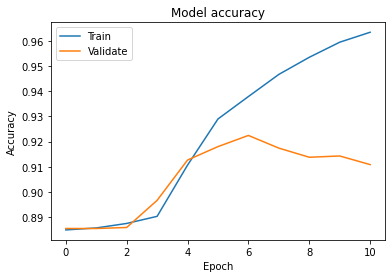

In [18]:
plt.figure()
# Use the history metrics
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# Make it pretty
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validate'])
plt.show()

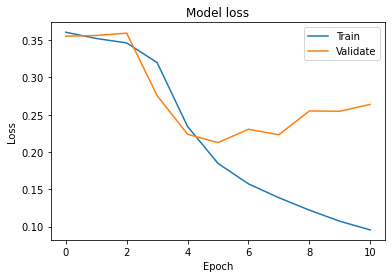

In [19]:
plt.figure()
# Use the history metrics
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# Make it pretty
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validate'])
plt.show()

In [20]:
model.evaluate(X_test, y_test)

172/172 [==============================] - 53s 287ms/step - loss: 0.2597 - accuracy: 0.9122


[0.25965678691864014, 0.9122137427330017]

In [21]:
tes = "I entered the school happily, after seeing how hectic the school was, and how annoying the rules were, I got furious, and started looking forward to the day I would leave"

tes = [preprocess(tes)]

tes = tokenizer.texts_to_sequences(tes)
tes = pad_sequences(tes, padding='post', maxlen=maxlen)

In [25]:
model.predict(tes)

array([[0.28682792]], dtype=float32)

In [27]:
tes1 = "The school is quite amazing, from the gates to the hostels, looking at all the structures, it was beyond my expectations"

tes1 = [preprocess(tes1)]

tes1 = tokenizer.texts_to_sequences(tes1)
tes1 = pad_sequences(tes1, padding='post', maxlen=maxlen)

In [28]:
model.predict(tes1)

array([[0.9943583]], dtype=float32)